## NK landscape

Example from https://link.springer.com/article/10.1186/s41469-018-0039-0

In [2]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from itertools import product
import networkx as nx

How to understand it:
- Dependencies show which nodes are connected [0,1] means node zero impacts one
- C displays the value of connections
    - The first row is for the first node and the value of all its connections

In [4]:
# Interaction matrix
K = 1
N = 3
assert K+1 <= N
I = np.array([[1,0,1],[1,1,0],[0,1,1]])

print(I)

[[1 0 1]
 [1 1 0]
 [0 1 1]]


In [5]:
combs = np.array(list(product([0,1], repeat=K+1)))
combs

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [6]:
C = np.zeros((N, len(combs),))
# Values from example
C[0] = np.array([0.9, .5, .3, .7])
C[1] = np.array([0.8, 0, 0, 0.3])
C[2] = np.array([.1, .5, .2, .9])
C

array([[0.9, 0.5, 0.3, 0.7],
       [0.8, 0. , 0. , 0.3],
       [0.1, 0.5, 0.2, 0.9]])

In [7]:
def create_C(N, K):
    C = np.random.random((N,2**(K+1))).round(1)
    return C

In [8]:
create_C(3, 1)

array([[0.7, 0.8, 0.1, 0.6],
       [0.8, 0.3, 0.5, 0.8],
       [0.9, 0.5, 1. , 0.3]])

In [9]:
# TODO: Dependencies are always in same direction (make it random)
def create_dependency(N, K):
    """[:,0] is connected with [:,1] --> [0,1] would mean node 0 has fluence on node 1"""
    assert N >= K+1
    depend = np.zeros((N*K, 2))
    x = np.arange(N)
    for _ in range(K):
        depend[:,0][N*_: N*_ +N] = x
        depend[:,1][N*_: N*_ +N] = np.roll(x,_+1)

    return depend.astype(int)

In [10]:
# TODO: Dependencies are always in same direction (roll command) (make it random)
def create_multiple_dependencies(N, K):
    """[:,0] is connected with [:,1] --> [0,1] would mean node 0 has fluence on node 1"""
    assert N >= K+1
    depend = np.zeros((N, K+1))
    x = np.arange(N)
    
    depend[:,0] = x
    
    for _ in range(K):
        depend[:,_+1] = np.roll(x,_+1)

    return depend.astype(int)

In [11]:
# Alternative (not working) with networkx
K=2
G = nx.random_k_out_graph(N, K, 1, self_loops=False)
nx.to_numpy_array(G).astype(int)

array([[0, 2, 0],
       [1, 0, 1],
       [0, 2, 0]])

In [12]:
N = 4
K = 2
create_multiple_dependencies(N, K)

array([[0, 3, 2],
       [1, 0, 3],
       [2, 1, 0],
       [3, 2, 1]])

In [13]:
def f(v, conns, C):
    assert len(v) == N
    solution = []
    for i in range(len(conns)):
        for j, comb in enumerate(combs):
            if ([v[conns[i][_]] for _ in range(K+1)] == comb).all():
                solution.append(C[i][j])
    return solution, round(np.array(solution).mean(), 2)

In [14]:
N = 5
K = 2
combs = np.array(list(product([0,1], repeat=K+1)))
C = create_C(N, K)
# conns = create_dependency(N, K)
conns = create_multiple_dependencies(N, K)


In [15]:
v = np.array([0, 0, 1, 0, 1])
f(v, conns, C)

([0.9, 0.5, 0.8, 0.2, 0.2], 0.52)

In [16]:
C, conns, combs

(array([[0.2, 0.2, 0.9, 0.1, 0.8, 0.5, 0.4, 0. ],
        [0.3, 0.5, 0.5, 0.2, 0.7, 0.6, 0.4, 0.9],
        [1. , 1. , 0.8, 0.7, 0.8, 0.9, 0.4, 0.6],
        [0.6, 0.2, 0.2, 1. , 0.7, 0.7, 0.9, 0.2],
        [0.7, 0.7, 1. , 0.5, 0.2, 0.2, 0.4, 0.6]]),
 array([[0, 4, 3],
        [1, 0, 4],
        [2, 1, 0],
        [3, 2, 1],
        [4, 3, 2]]),
 array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]))

Branch and Bound algorithm to find optimum

In [17]:
# Brute force
all_solutions = []
for sol in np.array(list(product([0,1], repeat=N))):
    all_solutions.append(f(sol, conns, C)[1])
max(all_solutions)

0.74

In [18]:
class NK_landscape():
    
    def __init__(self, N=8, K=3, C = None, dependencies = None):
        assert N >= K+1
        
        self.N = N
        self.K = K
        
        if C is None or dependencies is None:
            self.initialize_C()
            self.initialize_dependencies()
        else:
            self.dependencies = dependencies
            self.C = C

        
        self.combinations = np.array(list(product([0,1], repeat=K+1)))
        self.max_value = None
        self.min_value = None
        
        self.fitness_dict = {}
        
        self.init_values()
        
    
    def initialize_dependencies(self):
        """[:,0] is connected with [:,1] --> [0,1] would mean node 0 has fluence on node 1"""
        depend = np.zeros((self.N, self.K+1))
        x = np.arange(self.N)
        depend[:,0] = x
        for _ in range(self.K):
            depend[:,_+1] = np.roll(x,_+1)

        self.dependencies = depend.astype(int)
    
    def initialize_C(self):
        self.C = np.random.random((self.N,2**(self.K+1))).round(1)

    def f(self, state):
        assert len(state) == self.N
        solution = []
        for i in range(len(self.dependencies)):
            for j, comb in enumerate(self.combinations):
                if ([state[self.dependencies[i][_]] for _ in range(self.K+1)] == comb).all():
                    solution.append(self.C[i][j])
        
        return solution, round(np.array(solution).mean(), 2)
    
    def init_values(self):
        # all_solutions = []
        max_val = 0
        min_val = 2
        for sol in np.array(list(product([0,1], repeat=self.N))):
            key = int("".join(map(str, sol)), 2)
            value = self.f(sol)[1]
            
            # all_solutions.append(value)
            self.fitness_dict[key] = value
          
            if max_val < value:
                max_val = value
            if min_val > value:
                min_val = value
        self.max_value = max_val
        self.min_value = min_val
        
    
    def old_fitness(self, state):
        assert self.max_value != None
        return np.round((self.f(state)[1] - self.min_value) / (self.max_value - self.min_value), 2)
    
    def get_scaled_fitness(self, state):
        key = int("".join(map(str, state)), 2)
        value = self.fitness_dict[key]
        return np.round((value - self.min_value) / (self.max_value - self.min_value), 2)

In [19]:
landscape = NK_landscape(3,1)

In [20]:
print(landscape.C, landscape.dependencies, landscape.combinations)
state = np.array([0,1,1])
landscape.f(state)

[[0.  0.9 0.4 0.1]
 [1.  0.  0.9 0.7]
 [0.7 0.4 0.7 0.4]] [[0 2]
 [1 0]
 [2 1]] [[0 0]
 [0 1]
 [1 0]
 [1 1]]


([0.9, 0.9, 0.4], 0.73)

### Compare fitness speed (dict to on the run)
Calculate on the run compared to dict

In [34]:
start = timeit.default_timer()
N, K = 10, 5
env = NK_landscape(N, K)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  5.6421730999999795


In [35]:
import timeit

In [36]:
start = timeit.default_timer()
for state in list(product([0,1], repeat=N)):
    env.old_fitness(state)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  4.770461799999964


In [37]:
start = timeit.default_timer()
for state in list(product([0,1], repeat=N)):
    env.get_scaled_fitness(state)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  0.015894300000013573


### Algorithms
#####  Local Search
- Hill Climbing
    - Greedy
    - Stochastic
    - First choice
    - Random restart
- Simulated Annealing
- Local beam search
    - stochastic beam search
- Genetic algorithms




In [330]:
N, K = 8, 4
env = NK_landscape(8, 4) # 2**8 = 256
state = np.zeros(N)
print(env.max_value()); print(env.f(state)[1]); print(env.get_scaled_fitness(state))

0.81
0.56
0.69


In [343]:
def softmax(new_score, old_score, b=10):
    return np.exp(new_score*b) / np.sum([np.exp(new_score*b), np.exp(old_score*b)])

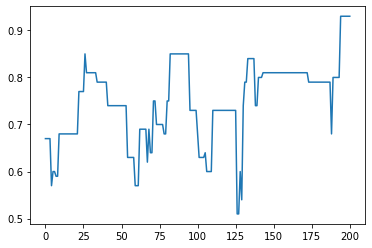

In [345]:
# Hill Climbing
rng = np.random.default_rng(0)

def SHC(env, iterations, rng):
    state = np.round(rng.random(env.N)).astype(int)

    score = env.get_scaled_fitness(state)
    # print(f"Start fitness / state: {score} / {state}")

    # iterations = 300
    all_scores = np.zeros(iterations+1)
    all_scores[0] = score

    for i in range(iterations):
        new_state = state
        digit = rng.integers(0, env.N)
        if state[digit] == 1:
            new_state[digit] = 0
        else:
            new_state[digit] = 1
        new_score = env.get_scaled_fitness(new_state)

        # if new_score >= score:
        if rng.random() <= softmax(new_score, score, 15):
            state = new_state
            score = new_score

        all_scores[i+1] = score
        # print(f"{i}: {score}")
    # print(f"End   fitness / state: {score} / {state}")

    return all_scores

iterations = 200
all_scores = SHC(env, iterations, rng)  
plt.plot(all_scores)
# plt.plot(np.ones(iterations+1) * env.brute_force_max())

0
50
100
150
200
250


Text(0.5, 1.0, 'SHC of a single agent')

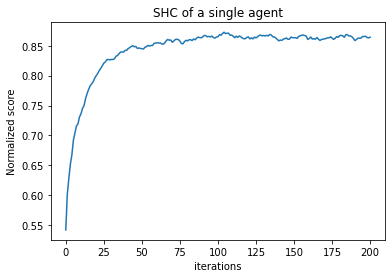

In [369]:
rng = np.random.default_rng(0)


iterations = 200
n_trials = 300
N, K = 10, 5


score_tracker = np.empty((n_trials, iterations+1))
env = NK_landscape(N, K)
env.brute_force_max()

for i in range(n_trials):
    score_tracker[i] = SHC(env, iterations, rng)
    if i%50 == 0:
        print(i)
    
plt.plot(score_tracker.mean(axis=0))
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title("SHC of a single agent")

In [370]:
# Hill Climbing + random exploration

def SHC_exploration(env, iterations, rng):
    state = np.round(rng.random(env.N)).astype(int)

    score = env.get_scaled_fitness(state)
    # print(f"Start fitness / state: {score} / {state}")

    # iterations = 300
    all_scores = np.zeros(iterations+1)
    all_scores[0] = score

    for i in range(iterations):
        new_state = state
        digit = rng.integers(0, env.N)
        
        # Random exploration
        if 0.2 >= rng.random():
            new_state = np.round(rng.random(env.N)).astype(int)
            new_score = env.get_scaled_fitness(new_state)
            
            if new_score > score:
                state = new_state
                score = new_score
                continue
        # SHC
        else:
            if state[digit] == 1:
                new_state[digit] = 0
            else:
                new_state[digit] = 1
            new_score = env.get_scaled_fitness(new_state)

            # if new_score >= score:
            if rng.random() <= softmax(new_score, score, 15):
                state = new_state
                score = new_score

        all_scores[i+1] = score
        # print(f"{i}: {score}")
    # print(f"End   fitness / state: {score} / {state}")

    return all_scores


0
50
100
150
200
250


Text(0.5, 1.0, 'SHC with random exploration of a single agent')

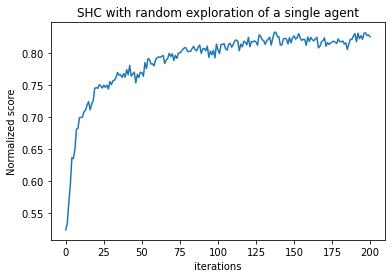

In [371]:
rng = np.random.default_rng(0)


iterations = 200
n_trials = 300
N, K = 10, 5


score_tracker2 = np.empty((n_trials, iterations+1))
env = NK_landscape(N, K)
env.brute_force_max()

for i in range(n_trials):
    score_tracker2[i] = SHC_exploration(env, iterations, rng)
    if i%50 == 0:
        print(i)
    
plt.plot(score_tracker2.mean(axis=0))
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title("SHC with random exploration of a single agent")

In [372]:
score_tracker.mean(), score_tracker2.mean()

(0.8432902155887232, 0.7897810945273631)

### Save some landscapes to a file

In [59]:
class NK_landscape_loaded(NK_landscape):
    
    def __init__(self, N, K, fitness_dict):
        assert N >= K+1
        
        self.N = N
        self.K = K

        
        self.max_value = None
        self.min_value = None
        
        self.fitness_dict = fitness_dict
        self.init_min_max()
                
    
    def f(self, state):
        raise NotImplementedError("Only dictionary in loaded nk landscape")
        
    
    def init_min_max(self):
        self.max_value = max(self.fitness_dict.values())
        self.min_value = min(self.fitness_dict.values())
        

In [52]:
import json
import pickle 

In [50]:
landscapes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [48]:
N = 10
K = 5

landscapes = {}

for seed in np.arange(30):
    rng = np.random.default_rng(seed)
    env = NK_landscape(N, K)
    landscapes[seed] = env.fitness_dict
    print(seed)

file = 'N10K5_30.json' 

with open(file, 'w') as f: 
    json.dump(landscapes, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


TypeError: key 0 is not a string

In [54]:
file = 'N10K5_30.pkl' 

with open(file, 'wb') as f:
    pickle.dump(landscapes, f)
        

In [56]:
with open(file, 'rb') as f:
    data = pickle.load(f)

In [58]:
data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [62]:
nk = NK_landscape_loaded(10, 5, data[0])
state = np.round(rng.random(env.N)).astype(int)
nk.get_scaled_fitness(state)

0.45